### Introduction

In this project we take a look at a kaggle competition data-set(https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting). In this challenge we have to predict the number of customers that will visit a particular restaurant, using past restaurant reservations and customer statistics.

There are two sources from where the data has been collected:

1. Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
+ AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

In [17]:
#Loading the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gamma
from sklearn.cluster import KMeans 

In all the following analysis we take a look only at the air data.

In [32]:
#Loading all the required files using pandas package
air_store = pd.read_csv('air_store_info.csv')
air_reserve = pd.read_csv('air_reserve.csv')
air_visit = pd.read_csv('air_visit_data.csv')
date_info = pd.read_csv('date_info.csv')

### Visualizing the statistics

We first look at the distribution of the arrival based on the location of the restaurant.

Since we do not know the exact location of these shops we cluster them into 10 groups using k-means clustering. This idea for grouping restaurants was first implemented here (https://www.kaggle.com/asindico/a-japanese-journey).

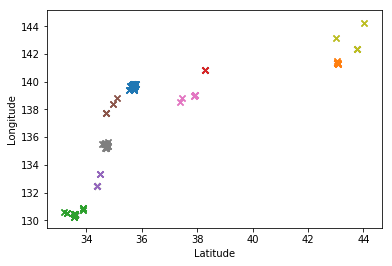

In [33]:
cluster_size = 10

location_kmeans = KMeans(n_clusters=cluster_size, random_state=0).fit(air_store[['latitude','longitude']])
air_store['cluster'] = location_kmeans.predict(air_store[['latitude','longitude']])

for i in range(cluster_size):
    x = np.array(air_store.loc[air_store.cluster==(i+1),'latitude'])
    y = np.array(air_store.loc[air_store.cluster==(i+1),'longitude'])
    plt.scatter(x,y,marker='x')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In the above plot, each color represents a cluster.


In [42]:
list_of_air_genre = list(set(air_store.air_genre_name))
num_air_genre = len(list_of_air_genre)

print('The restaurants are also grouped into different genres which are -')

for i in list_of_air_genre:
    print(i)

The restaurants are also grouped into different genres which are -
Western food
Cafe/Sweets
Italian/French
Yakiniku/Korean food
Okonomiyaki/Monja/Teppanyaki
Karaoke/Party
Japanese food
International cuisine
Other
Creative cuisine
Izakaya
Bar/Cocktail
Asian
Dining bar


Looking at the statistics of all individual restaurant for an entire year was not feasible as there were over 800 restaurants data tracked. It was more viable to look at the statistics of each cluster conditioned on various parameters such as day of the week and the kind of genre.

In [8]:
day_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

air_visit_day = pd.merge(air_visit,date_info,left_on='visit_date',right_on='calendar_date')
air_visit_day_genre = pd.merge(air_visit_day,air_store.loc[:,['air_store_id','air_genre_name']],on='air_store_id')
air_visit_day_genre_cluster = pd.merge(air_visit_day_genre,air_store[['air_store_id','cluster']],on='air_store_id')

For each of the conditioned distribution, we checked to see if it follows any particular distribution.The two distributions we tired were :
* poisson distribution
* gamma distribution

#### Poisson distribution
$$p(X=n) = \frac{(\mu)^n}{n!}*e^{-\mu} \quad,n>0$$

#### Gamma distribution
$$p(X;\alpha,\beta) = \beta^\alpha \frac{x^{\alpha -1}}{\alpha !} * e^{-x} \quad,x>0,\alpha \in \mathbb{R}$$

As the number of customers is a variable that is always non-negative and as n becomes quite large the distribution should be zero, these two distributions does seem viable.

In the following cell, we keep the value of $\alpha$ at 5 and try to fit these curves to the data.

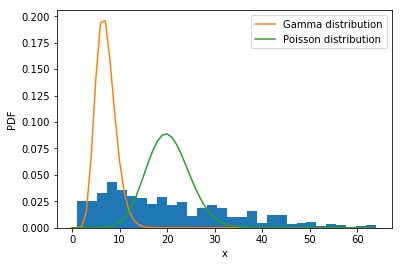

In [73]:
#Any number between 0 and 9
cluster_num = 3
genre_type = list_of_air_genre[2]
day = 'Friday'

visitors_cluster_genre = air_visit_day_genre_cluster.loc[air_visit_day_genre_cluster.day_of_week==day,['visitors','air_genre_name','cluster']]    
visitors_cluster = visitors_cluster_genre.loc[visitors_cluster_genre.air_genre_name==genre_type,['visitors','cluster']]
visitors = visitors_cluster.loc[visitors_cluster.cluster==cluster_num,'visitors']

#Fitting the distribution to a poisson distribution
mu = np.mean(visitors)
samples = range(0,max(visitors))
pdf_samples = [poisson.pmf(k,mu,loc=0) for k in samples]

#Fitting the distribution to a gamma distribution
a = 12
scale = a/(np.mean(visitors))
samples = range(0,max(visitors))
pdf_samples2 = [gamma.pdf(k,a,loc=0,scale=scale) for k in samples]

plt.hist(visitors,bins=30,normed =True)
plt.plot(samples,pdf_samples2,label='Gamma distribution')
plt.plot(samples,pdf_samples,label='Poisson distribution')
plt.legend()
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

In several of the conditions it is observed that the poisson distribution varies a lot from the histogram of the data, while gamma distribution does match to some extent to the histogram. But both these distributions rapidly decease as x becomes larger.

### Linear Estimator

Thus to estimate the number of customers who visit in a particular day, a simple regression model was used. The model is given by:
$$ N[t] = \sum\limits_{i=1}^5 a_i*N[t-i]$$
where $N[t]$ is the number of customers that visit in day t.

To estimate the coefficients $a_i$, the set of parmeters that reduce the mean squared error was chosen.


In [75]:
#function to estimate the coefficients of the linear regression
def H_hat(data,y):
    row = len(y)
    data = np.flipud(data)
    y = np.flipud(y)
    Cxx = np.zeros([5,5])
    Cxy = np.zeros([1,5])
    for i in range(row):
            Cxx = Cxx + np.matmul(data[i:i+5].reshape(-1,1),data[i:i+5].reshape(1,5))
            Cxy = Cxy + data[i:i+5]*y[i]
    Cxx = Cxx/row
    Cxy = Cxy/row
    return np.linalg.solve(Cxx,Cxy.reshape(-1,1))

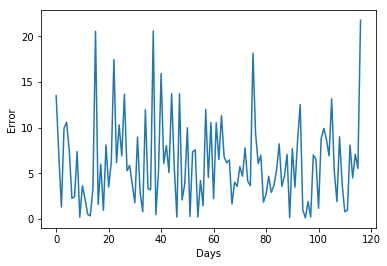

In [83]:
#Predicting for a single hotel
store_no = 111 #Any Number for between 0-828
list_air_store_id = air_store['air_store_id']
visitors = np.array(air_visit.loc[air_visit.air_store_id==list_air_store_id[10],'visitors'])

Error = []

for i in range(31,len(visitors)-1):
    H = H_hat(visitors[i-31:i-1],visitors[i-25:i])
    #H = H_hat(visitors[0:30],visitors[4:31])
    N = np.matmul(H.reshape(1,-1),np.flipud(visitors[i-6:i-1]))
    Error.append(abs(N-visitors[i]))

plt.plot(Error)
plt.xlabel('Days')
plt.ylabel('Error')
plt.show()

The above graph show the error in estimating the number of visits for one hotel.

Although there are large variations, it is interesting to observe the power of a simple regression model that is able to predict to some degree of accuracy the number of visitors.